In [ ]:
!pip install transformers pandas torch scikit-learn matplotlib tqdm seaborn requests datasets trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from dataset_download import (
    download_dataset,
    prepare_dataset,
    get_dataset
)

from ai_detector import (
    get_device,
    load_model_and_tokenizer,
    preprocess_data,
    create_dataloaders,
    train_model,
    evaluate_model,
    plot_metrics,
    predict_text,
    save_model,
    split_data
)

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from datasets import load_dataset

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
random.seed(RANDOM_SEED)

device = get_device()

Using device: cuda


In [ ]:
print("Getting dataset...")
hc3_df = get_dataset()  # Reduced for Colab

print("\nDataset Overview:")
print(f"Total samples: {len(hc3_df)}")
print(f"Human-written samples: {sum(hc3_df['label'] == 0)}")
print(f"AI-generated samples: {sum(hc3_df['label'] == 1)}")

print("\nSample Human Text:")
if len(hc3_df[hc3_df['label'] == 0]) > 0:
    print(hc3_df[hc3_df['label'] == 0]['text'].iloc[0][:200] + "...")

print("\nSample AI Text:")
if len(hc3_df[hc3_df['label'] == 1]) > 0:
    print(hc3_df[hc3_df['label'] == 1]['text'].iloc[0][:200] + "...")

Getting dataset...
Loading HC3 dataset from Hugging Face...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting and saving data...
Dataset saved to HC3_all_hf.csv
Total samples: 85431, Human: 58546, AI: 26885
Preparing HC3_all_hf.csv...
Dataset already in expected format.
Dataset prepared with 4000 samples:
  - Human texts: 2000
  - AI texts: 2000
Saved to prepared_dataset.csv

Dataset Overview:
Total samples: 4000
Human-written samples: 2000
AI-generated samples: 2000

Sample Human Text:
Yes, you can open a Trading Account at one place and a Demat Account at another place. Therefore you can open Trading Account at Sharekhan and Demat Account at OBC. However, it would be more convenien...

Sample AI Text:
Image de-noising is the process of removing noise from an image. Noise is a random variation of brightness or color information in an image, and it can be caused by a variety of factors such as image ...


In [ ]:

train_df, val_df, test_df = split_data(hc3_df, test_size=0.3, random_state=RANDOM_SEED)

roberta_tokenizer, roberta = load_model_and_tokenizer(device)

print("\nPreprocessing data...")
train_dataset_hc3 = preprocess_data(train_df, roberta_tokenizer)
val_dataset_hc3 = preprocess_data(val_df, roberta_tokenizer)
test_dataset_hc3 = preprocess_data(test_df, roberta_tokenizer)

batch_size = 8  # Reduced for Colab
train_dataloader_hc3, val_dataloader_hc3, test_dataloader_hc3 = create_dataloaders(
    train_dataset_hc3, val_dataset_hc3, test_dataset_hc3, batch_size=batch_size
)

Train set: 2800 samples
Validation set: 600 samples
Test set: 600 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Preprocessing data...


In [ ]:

print("\nTraining model...")
epochs = 1
roberta_training_stats = train_model(roberta, train_dataloader_hc3, val_dataloader_hc3, epochs=epochs, device=device)


Training model...
======== Epoch 1 / 1 ========


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Average training loss: 0.0888


Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Accuracy: 0.9950
Validation F1: 0.9950
Validation AUROC: 0.9999


/content/ai_detector.py:151: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  probs = torch.softmax(torch.tensor(logits_all), dim=1)[:, 1].numpy()



Evaluating on test set...


Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Test Accuracy: 0.9950
Test Precision: 0.9934
Test Recall: 0.9967
Test F1 Score: 0.9950
Test AUROC: 0.9998
Plotting metrics...


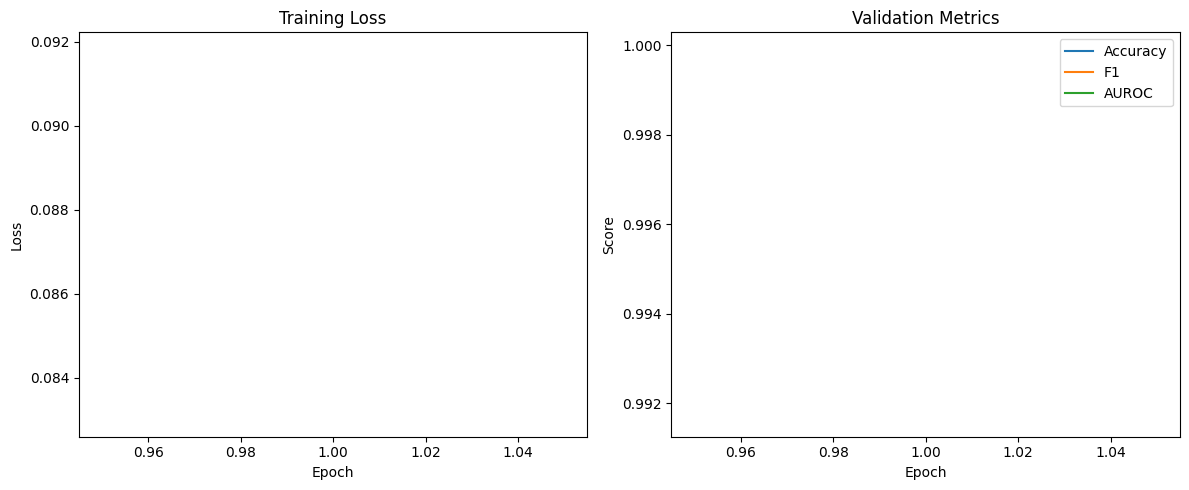

Model and tokenizer saved to roberta_ai_detector

Demo Predictions:

Text: The quick brown fox jumps over the lazy dog. This ...
Prediction: Human-written
Human probability: 0.7190
AI probability: 0.2810

Text: As an AI language model, I am designed to generate...
Prediction: Human-written
Human probability: 0.8666
AI probability: 0.1334


In [ ]:

print("\nEvaluating on test set...")
test_metrics_roberta = evaluate_model(roberta, test_dataloader_hc3, device)

print(f"Test Accuracy: {test_metrics_roberta['accuracy']:.4f}")
print(f"Test Precision: {test_metrics_roberta['precision']:.4f}")
print(f"Test Recall: {test_metrics_roberta['recall']:.4f}")
print(f"Test F1 Score: {test_metrics_roberta['f1']:.4f}")
print(f"Test AUROC: {test_metrics_roberta['auroc']:.4f}")

print("Plotting metrics...")
plot_metrics(roberta_training_stats)

save_model(roberta, roberta_tokenizer, "roberta_ai_detector")

demo_texts = [
    "The quick brown fox jumps over the lazy dog. This is a test of human writing.",
    "As an AI language model, I am designed to generate text based on patterns learned during training."
]

print("\nDemo Predictions:")
for text in demo_texts:
    result = predict_text(text, roberta, roberta_tokenizer, device)
    print(f"\nText: {text[:50]}...")
    print(f"Prediction: {result['prediction']}")
    print(f"Human probability: {result['human_probability']:.4f}")
    print(f"AI probability: {result['ai_probability']:.4f}")

In [ ]:

roft_ds = load_dataset("liamdugan/roft", split="train")

roft_df = pd.DataFrame(roft_ds)

print(roft_df.columns)

README.md:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

roft.csv:   0%|          | 0.00/41.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27614 [00:00<?, ? examples/s]

Index(['date', 'model', 'dataset', 'annotator', 'group', 'dec_strat_value',
       'predicted_boundary_index', 'true_boundary_index', 'points', 'reason',
       'prompt', 'prompt_body', 'generation', 'gen_body', 'recipe_familiarity',
       'news_familiarity', 'stories_familiarity', 'gen_familiarity',
       'native_speaker', 'read_guide'],
      dtype='object')


In [ ]:
# Filter: AI samples → gen_body is not null
ai_df = roft_df[roft_df['gen_body'].notna()].copy()
ai_df['text'] = ai_df['prompt_body'] + " " + ai_df['gen_body']
ai_df['label'] = 1  # AI-generated

human_df = roft_df[roft_df['gen_body'].isna()].copy()
human_df['text'] = human_df['prompt_body']
human_df['label'] = 0  # Human-written

combined_df = pd.concat([ai_df[['text', 'label']], human_df[['text', 'label']]])
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Sample breakdown:")
print(combined_df['label'].value_counts())

Sample breakdown:
label
1    24217
0     3397
Name: count, dtype: int64


In [ ]:
SUBSET = 500
ai_sample = ai_df.sample(n=SUBSET, random_state=42)
human_sample = human_df.sample(n=SUBSET, random_state=42)

subset_df = pd.concat([ai_sample, human_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

eval_dataset_roft = preprocess_data(subset_df, roberta_tokenizer)
eval_loader_roft = DataLoader(eval_dataset_roft, batch_size=8)

In [ ]:
# Eval roberta on roft
results = evaluate_model(roberta, eval_loader_roft, device)

print("Evaluation on ROFT:")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"F1 Score: {results['f1']:.4f}")
print(f"AUROC: {results['auroc']:.4f}")

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation on ROFT:
Accuracy: 0.5190
F1 Score: 0.2634
AUROC: 0.3929


In [ ]:
!git clone https://github.com/eric-mitchell/detect-gpt.git detectgpt
# Replace run.py

In [ ]:
human_texts = combined_df[combined_df['label'] == 0]['text'].tolist()
ai_texts = combined_df[combined_df['label'] == 1]['text'].tolist()

# Ensure same length
min_len = min(len(human_texts), len(ai_texts))
data = {
    "original": human_texts[:min_len],
    "sampled": ai_texts[:min_len]
}

import json
with open("roft_input.json", "w") as f:
    json.dump(data, f)

In [ ]:
with open("roft_input.json", "r") as f:
    d = json.load(f)

assert isinstance(d["original"], list)
assert isinstance(d["sampled"], list)
assert len(d["original"]) == len(d["sampled"])
print(f"✅ Loaded {len(d['original'])} samples (balanced)")
print(f"First sample (original): {d['original'][0][:100]}")
print(f"First sample (sampled):  {d['sampled'][0][:100]}")


✅ Loaded 3397 samples (balanced)
First sample (original): I kept my head low as I walked through the school hallway on my way back from lunch._SEP_Not that we
First sample (sampled):  "Address to the Nation on Immigration" by President Barack Obama on November 20, 2014._SEP_My fellow


In [ ]:
# !wget https://huggingface.co/gpt2/resolve/main/tokenizer_config.json -O tokenizer_config.json
# !mkdir -p /root/.cache/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e
# !mv tokenizer_config.json /root/.cache/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e

# !rm /root/.cache/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/tokenizer_config.json
!rm -f /root/.cache/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/tokenizer_config.json


In [ ]:
from transformers import GPT2Tokenizer
GPT2Tokenizer.from_pretrained("gpt2")  # no need for force_download

GPT2Tokenizer(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [ ]:
!python detectgpt/run.py \
  --dataset roft_input.json \
  --dataset_key original \
  --base_model_name gpt2-medium \
  --mask_filling_model_name t5-large \
  --span_length 3 \
  --n_samples 3397 \
  --n_perturbation_list 1 \
  --output_name roft_detectgpt

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Saving results to absolute path: /content/tmp_results/roft_detectgpt/gpt2-medium-t5-large-temp/2025-05-07-21-16-01-290270-fp32-0.3-1-roft_input.json-3397
Using cache dir ~/.cache
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
tokenizer_config.json: 100% 26.0/26.0 [00:00<00:00, 195kB/s]
vocab.json: 100% 1.04M/1.04M [00:00<00:00, 65.7MB/s]
merges.txt: 100% 456k/456k [00:00<00:00, 20.5MB/s]
tokenizer_config.json: 100% 26.0/26.0 [00:00<00:00, 188kB/s]
tokenizer.json: 100% 1.36M/1.36M [00:00<00:00, 5.71MB/s]
Load

In [ ]:
!python detectgpt/run.py \
  --dataset roft_input.json \
  --dataset_key original \
  --base_model_name gpt2-medium \
  --mask_filling_model_name t5-base \
  --skip_baselines \
  --span_length 3 \
  --n_samples 1000 \
  --n_perturbation_list 1 \
  --chunk_size 4 \
  --output_name roft_detectgpt_light


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Saving results to absolute path: /content/tmp_results/roft_detectgpt_light/gpt2-medium-t5-base-temp/2025-05-07-21-54-27-427147-fp32-0.3-1-roft_input.json-1000
Using cache dir ~/.cache
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
tokenizer_config.json: 100% 26.0/26.0 [00:00<00:00, 199kB/s]
vocab.json: 100% 1.04M/1.04M [00:00<00:00, 1.58MB/s]
merges.txt: 100% 456k/456k [00:00<00:00, 2.10MB/s]
tokenizer_config.json: 100% 26.0/26.0 [00:00<00:00, 194kB/s]
tokenizer.json: 100% 1.36M/1.36M [00:00<00:00, 3.14MB/s]

#zeroshot for roberta

In [ ]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch.nn.functional as F
import numpy as np

# Load T5 for perturbation
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

# def mask_and_perturb(text, n=10, span_length=3, mask_token="<<<mask>>>"):
#     """
#     Generate N perturbed versions of the input using T5 masked infill.
#     """
#     tokens = text.split()
#     perturbed = []
#     for _ in range(n):
#         masked = tokens.copy()
#         start = np.random.randint(0, max(1, len(tokens) - span_length))
#         masked[start:start+span_length] = [mask_token]
#         masked_text = " ".join(masked).replace(mask_token, "<extra_id_0>")
#         input_ids = t5_tokenizer(masked_text, return_tensors="pt").input_ids.to(device)
#         output_ids = t5_model.generate(input_ids, max_new_tokens=span_length+3)
#         fill = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
#         filled = masked_text.replace("<extra_id_0>", fill)
#         perturbed.append(filled)
#     return perturbed

def mask_and_perturb(text, n=10, span_length=3, n_spans=2):
    tokens = text.split()
    perturbed = []
    for _ in range(n):
        masked = tokens.copy()
        for span in range(n_spans):
            start = np.random.randint(0, max(1, len(tokens) - span_length))
            masked[start:start+span_length] = [f"<extra_id_{span}>"]
        masked_text = " ".join(masked)
        input_ids = t5_tokenizer(masked_text, return_tensors="pt").input_ids.to(device)
        output_ids = t5_model.generate(input_ids, max_new_tokens=span_length * n_spans + 5)
        fill = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
        # Just drop fills in — coarse approximation
        filled = masked_text.replace("<extra_id_0>", fill)
        perturbed.append(filled)
    return perturbed


def roberta_zero_shot_score(text, model, tokenizer, n_perturbations=10, method='variance'):
    """
    DetectGPT-style zero-shot scoring using RoBERTa classification stability.

    Args:
        text (str): Original text
        model (nn.Module): RoBERTa model
        tokenizer: Tokenizer for RoBERTa
        n_perturbations (int): Number of perturbations
        method (str): 'variance' or 'delta'

    Returns:
        float: Stability score (higher = more likely AI)
    """
    model.eval()
    with torch.no_grad():
        # Score original
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)
        orig_logits = model(**inputs).logits
        orig_prob = F.softmax(orig_logits, dim=-1)[0, 1].item()  # P(AI)

        # Perturb
        perturbed_texts = mask_and_perturb(text, n=n_perturbations)
        probs = []
        for pt in perturbed_texts:
            inputs = tokenizer(pt, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)
            logits = model(**inputs).logits
            prob = F.softmax(logits, dim=-1)[0, 1].item()
            probs.append(prob)

        if method == 'variance':
            return np.var(probs)
        elif method == 'delta':
            return orig_prob - np.mean(probs)
        else:
            raise ValueError("method must be 'variance' or 'delta'")


In [ ]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch.nn.functional as F
import numpy as np

# Load T5 for perturbation
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

def mask_and_perturb_multi(text, n=10, span_length=3, n_spans=2):
    """
    Generate N perturbed versions of the input by masking multiple spans.
    """
    tokens = text.split()
    perturbed = []

    for _ in range(n):
        masked = tokens.copy()
        used = set()
        for span_id in range(n_spans):
            attempts = 0
            while attempts < 10:
                start = np.random.randint(0, max(1, len(tokens) - span_length))
                if all(i not in used for i in range(start, start + span_length)):
                    for i in range(start, start + span_length):
                        used.add(i)
                    masked[start:start+span_length] = [f"<extra_id_{span_id}>"]
                    break
                attempts += 1

        masked_text = " ".join(masked)
        input_ids = t5_tokenizer(masked_text, return_tensors="pt").input_ids.to(device)
        output_ids = t5_model.generate(input_ids, max_new_tokens=span_length * n_spans + 5)
        fill = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
        filled = masked_text.replace("<extra_id_0>", fill)  # Coarse fill
        perturbed.append(filled)

    return perturbed

def entropy(probs):
    probs = np.clip(probs, 1e-6, 1.0)
    return -np.sum(probs * np.log(probs), axis=1)

def roberta_zero_shot_score_v2(text, model, tokenizer, n_perturbations=10, span_length=3, n_spans=2):
    model.eval()
    entropies = []

    with torch.no_grad():
        perturbed_texts = mask_and_perturb_multi(text, n=n_perturbations, span_length=span_length, n_spans=n_spans)

        for pt in perturbed_texts:
            inputs = tokenizer(pt, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)
            logits = model(**inputs).logits
            softmax_probs = F.softmax(logits, dim=-1)[0].cpu().numpy()
            entropies.append(entropy(np.array([softmax_probs]))[0])

    return float(np.mean(entropies))


In [ ]:
def evaluate_zero_shot_on_texts(texts, labels, model, tokenizer, method='variance', n_perturbations=5):
    scores = []
    for text in tqdm(texts, desc="Evaluating zero-shot"):
        score = roberta_zero_shot_score(
            text,
            model=model,
            tokenizer=tokenizer,
            n_perturbations=n_perturbations,
            method=method
        )
        scores.append(score)
    return scores, labels


In [ ]:
def evaluate_zero_shot_on_texts_v2(texts, labels, model, tokenizer, n_perturbations=5, span_length=3, n_spans=2):
    scores = []
    for text in tqdm(texts, desc="Evaluating zero-shot"):
        score = roberta_zero_shot_score_v2(
            text,
            model=model,
            tokenizer=tokenizer,
            n_perturbations=n_perturbations,
            span_length=3,
            n_spans=2
        )
        scores.append(score)
    return scores, labels


In [ ]:
from tqdm import tqdm
texts = subset_df['text'].tolist()
labels = subset_df['label'].tolist()

scores, labels = evaluate_zero_shot_on_texts(texts, labels, roberta, roberta_tokenizer, method='variance', n_perturbations=5)

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
auroc = roc_auc_score(labels, scores)
precision, recall, _ = precision_recall_curve(labels, scores)
pr_auc = auc(recall, precision)

print(f"Zero-Shot AUROC: {auroc:.4f}")
print(f"Zero-Shot PR AUC: {pr_auc:.4f}")

Evaluating zero-shot: 100%|██████████| 1000/1000 [11:37<00:00,  1.43it/s]

Zero-Shot AUROC: 0.4752
Zero-Shot PR AUC: 0.5375


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from tqdm import tqdm

# Run zero-shot scoring
# scores, labels = evaluate_zero_shot_roberta(eval_loader_roft, roberta, roberta_tokenizer, method='variance', n_perturbations=5)
scores, labels = evaluate_zero_shot_on_texts_v2(texts, labels, roberta, roberta_tokenizer, n_perturbations=5, span_length=3, n_spans=2)

auroc = roc_auc_score(labels, scores)
precision, recall, _ = precision_recall_curve(labels, scores)
pr_auc = auc(recall, precision)

print(f"Zero-Shot AUROC: {auroc:.4f}")
print(f"Zero-Shot PR AUC: {pr_auc:.4f}")

Evaluating zero-shot: 100%|██████████| 1000/1000 [11:25<00:00,  1.46it/s]

Zero-Shot AUROC: 0.4832
Zero-Shot PR AUC: 0.5283


In [ ]:
texts = subset_df['text'].tolist()
labels = subset_df['label'].tolist()

scores, labels = evaluate_zero_shot_on_texts(texts, labels, roberta, roberta_tokenizer, method='delta', n_perturbations=5)

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
auroc = roc_auc_score(labels, scores)
precision, recall, _ = precision_recall_curve(labels, scores)
pr_auc = auc(recall, precision)

print(f"Zero-Shot AUROC: {auroc:.4f}")
print(f"Zero-Shot PR AUC: {pr_auc:.4f}")

Evaluating zero-shot: 100%|██████████| 1000/1000 [11:16<00:00,  1.48it/s]

Zero-Shot AUROC: 0.3469
Zero-Shot PR AUC: 0.3943


In [ ]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

gpt2 = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
roberta_tokenizer, roberta = load_model_and_tokenizer(device)
roberta.eval()

lr = 5e-6
ppo_epochs = 4
eps_clip = 0.2
response_len = 32
max_len = 512
batch_size = 4
optimizer = torch.optim.AdamW(gpt2.parameters(), lr=lr)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df = get_dataset()
queries = df[df['label'] == 1]['text'].tolist()
queries = queries[:1000]  # Trim for Colab

Loading HC3 dataset from Hugging Face...
Extracting and saving data...
Dataset saved to HC3_all_hf.csv
Total samples: 85431, Human: 58546, AI: 26885
Preparing HC3_all_hf.csv...
Dataset already in expected format.
Dataset prepared with 4000 samples:
  - Human texts: 2000
  - AI texts: 2000
Saved to prepared_dataset.csv


In [ ]:
def compute_log_probs(model, input_ids, labels):
    output = model(input_ids=input_ids, labels=labels)
    log_probs = F.log_softmax(output.logits, dim=-1)
    return log_probs.gather(2, labels.unsqueeze(-1)).squeeze(-1)

for epoch in range(ppo_epochs):
    print(f"\n Epoch {epoch+1}")

    random.shuffle(queries)
    for i in range(0, len(queries), batch_size):
        batch = queries[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_len).to(device)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        context_len = input_ids.shape[1]

        with torch.no_grad():
            gen = gpt2.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=response_len,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )

        responses = gen[:, context_len:]
        full_input = torch.cat([input_ids, responses], dim=1)

        with torch.no_grad():
            old_log_probs = compute_log_probs(gpt2, full_input, full_input)

        texts = tokenizer.batch_decode(full_input, skip_special_tokens=True)
        rewards = []
        for t in texts:
            result = predict_text(t, roberta, roberta_tokenizer, device)
            reward = 1.0 - result["ai_probability"]
            rewards.append(reward)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)

        advantages = rewards - rewards.mean()

        new_log_probs = compute_log_probs(gpt2, full_input, full_input)
        log_ratio = new_log_probs - old_log_probs
        ratio = log_ratio.exp()

        advantages = advantages.unsqueeze(1).expand_as(ratio)

        unclipped = ratio * advantages
        clipped = torch.clamp(ratio, 1 - eps_clip, 1 + eps_clip) * advantages

        policy_loss = -torch.min(unclipped, clipped).mean()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i % 32 == 0:
            print(f"[{i}/{len(queries)}] Loss: {policy_loss.item():.4f} | Reward: {rewards.mean().item():.4f}")


🌀 Epoch 1
[0/1000] Loss: -0.0000 | Reward: 0.1052
[32/1000] Loss: 0.0000 | Reward: 0.0846
[64/1000] Loss: 0.0000 | Reward: 0.0523
[96/1000] Loss: -0.0000 | Reward: 0.1184
[128/1000] Loss: -0.0000 | Reward: 0.1115
[160/1000] Loss: -0.0000 | Reward: 0.2217
[192/1000] Loss: 0.0000 | Reward: 0.0523
[224/1000] Loss: -0.0000 | Reward: 0.1338
[256/1000] Loss: 0.0000 | Reward: 0.1165
[288/1000] Loss: -0.0000 | Reward: 0.0687
[320/1000] Loss: -0.0000 | Reward: 0.0854
[352/1000] Loss: 0.0000 | Reward: 0.1229
[384/1000] Loss: 0.0000 | Reward: 0.1263
[416/1000] Loss: -0.0000 | Reward: 0.1552
[448/1000] Loss: 0.0000 | Reward: 0.0291
[480/1000] Loss: -0.0000 | Reward: 0.0036
[512/1000] Loss: -0.0000 | Reward: 0.0032
[544/1000] Loss: -0.0000 | Reward: 0.0053
[576/1000] Loss: 0.0000 | Reward: 0.0319
[608/1000] Loss: -0.0000 | Reward: 0.0037
[640/1000] Loss: -0.0000 | Reward: 0.0010
[672/1000] Loss: -0.0000 | Reward: 0.0030
[704/1000] Loss: 0.0000 | Reward: 0.0794
[736/1000] Loss: -0.0000 | Reward: 0.

In [ ]:
from transformers import GPT2Tokenizer

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

def paraphrase_batch(batch_texts):
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    outputs = gpt2.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=32,
        do_sample=True,
        temperature=1.0,
        pad_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.batch_decode(outputs[:, inputs["input_ids"].shape[1]:], skip_special_tokens=True)


In [ ]:
ai_texts = df[df['label'] == 1]['text'].tolist()
paraphrased_texts = []

for i in range(0, len(ai_texts), 8):
    paraphrased_texts += paraphrase_batch(ai_texts[i:i+8])


In [ ]:
import pandas as pd

adv_df = pd.DataFrame({
    "text": paraphrased_texts,
    "label": [1] * len(paraphrased_texts),
})

human_df = df[df['label'] == 0][['text', 'label']]
combined_df_retrain = pd.concat([adv_df, human_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

In [ ]:
roberta_tokenizer, roberta = load_model_and_tokenizer(device)

train_dataset = preprocess_data(train_df, roberta_tokenizer)
val_dataset = preprocess_data(val_df, roberta_tokenizer)
train_loader, val_loader, _ = create_dataloaders(train_dataset, val_dataset, val_dataset, batch_size=8)

print("\nRetraining RoBERTa on adversarial samples...")
roberta_training_stats = train_model(roberta, train_loader, val_loader, epochs=1, device=device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Retraining RoBERTa on adversarial samples...
======== Epoch 1 / 1 ========


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Average training loss: 0.0806


Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Accuracy: 0.9950
Validation F1: 0.9950
Validation AUROC: 0.9999


In [ ]:
def tokenize_query(example):
    return ppo_tokenizer(example["query"], truncation=True, padding="max_length", max_length=512)
from datasets import Dataset
MAX_PROMPT_LEN = 448

def truncate_prompt(example):
    return ppo_tokenizer(example["query"], truncation=True, max_length=MAX_PROMPT_LEN)

ppo_dataset = Dataset.from_pandas(train_df[["text"]].rename(columns={"text": "query"}))
ppo_dataset = ppo_dataset.map(truncate_prompt, batched=False)
ppo_dataset = ppo_dataset.map(tokenize_query, batched=True)
ppo_dataset = ppo_dataset.remove_columns(["query", "__index_level_0__"])

In [ ]:
ppo_trainer = PPOTrainer(
    args=ppo_config,
    processing_class=ppo_tokenizer,
    model=ppo_model,
    ref_model=ref_model,
    reward_model=reward_model,
    value_model=value_model,
    train_dataset=ppo_dataset
)

In [ ]:
import os
os.environ["DISABLE_FLASH_ATTN"] = "1"
os.environ["TORCH_DISABLE_SDPA"] = "1"

ppo_trainer.train()

===training policy===


wandb: Currently logged in as: chenboshan1 (chenboshan11) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


🧪 attention_mask dtype: torch.bool
🧪 unique values: tensor([False,  True], device='cuda:0')


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
ppo_trainer = PPOTrainer(
    args=config,
    processing_class=ppo_tokenizer,
    model=ppo_model,
    ref_model=ref_model,
    reward_model=reward_model,
    train_dataset=train_dataset_hc3  # must be Hugging Face Dataset
)

AttributeError: 'NoneType' object has no attribute 'base_model_prefix'

In [ ]:
import torch.nn as nn

class RobertaRewardModel(nn.Module):
    def __init__(self, roberta_model, tokenizer, device):
        super().__init__()
        self.model = roberta_model
        self.tokenizer = tokenizer
        self.device = device

    def forward(self, queries, responses, **kwargs):
        texts = [q + " " + r for q, r in zip(queries, responses)]
        scores = []
        for text in texts:
            result = predict_text(text, self.model, self.tokenizer, self.device)
            scores.append(1.0 - result["ai_probability"])  # higher reward when fooled
        return torch.tensor(scores, dtype=torch.float32).to(self.device)


In [ ]:
import inspect
from trl import PPOConfig, PPOTrainer

print("=== PPOConfig Expected Args ===")
ppo_config_sig = inspect.signature(PPOConfig.__init__)
for param in ppo_config_sig.parameters.values():
    print(f"{param.name}: {param.default} ({param.annotation})")

print("\n=== PPOTrainer Expected Args ===")
ppo_trainer_sig = inspect.signature(PPOTrainer.__init__)
for param in ppo_trainer_sig.parameters.values():
    print(f"{param.name}: {param.default} ({param.annotation})")


=== PPOConfig Expected Args ===
self: <class 'inspect._empty'> (<class 'inspect._empty'>)
output_dir: None (typing.Optional[str])
overwrite_output_dir: False (<class 'bool'>)
do_train: False (<class 'bool'>)
do_eval: False (<class 'bool'>)
do_predict: False (<class 'bool'>)
eval_strategy: no (typing.Union[transformers.trainer_utils.IntervalStrategy, str])
prediction_loss_only: False (<class 'bool'>)
per_device_train_batch_size: 8 (<class 'int'>)
per_device_eval_batch_size: 8 (<class 'int'>)
per_gpu_train_batch_size: None (typing.Optional[int])
per_gpu_eval_batch_size: None (typing.Optional[int])
gradient_accumulation_steps: 1 (<class 'int'>)
eval_accumulation_steps: None (typing.Optional[int])
eval_delay: 0 (typing.Optional[float])
torch_empty_cache_steps: None (typing.Optional[int])
learning_rate: 5e-05 (<class 'float'>)
weight_decay: 0.0 (<class 'float'>)
adam_beta1: 0.9 (<class 'float'>)
adam_beta2: 0.999 (<class 'float'>)
adam_epsilon: 1e-08 (<class 'float'>)
max_grad_norm: 1.0 (<c

In [ ]:
from trl import PPOConfig, PPOTrainer
from transformers import AutoTokenizer
import inspect

# Collect required arguments for PPOConfig and PPOTrainer
ppo_config_args = inspect.signature(PPOConfig).parameters
ppo_trainer_args = inspect.signature(PPOTrainer).parameters

ppo_config_required = {k: v.default for k, v in ppo_config_args.items() if v.default is inspect.Parameter.empty}
ppo_trainer_required = {k: v.default for k, v in ppo_trainer_args.items() if v.default is inspect.Parameter.empty}

(ppo_config_required, ppo_trainer_required)

({},
 {'args': inspect._empty,
  'processing_class': inspect._empty,
  'model': inspect._empty,
  'ref_model': inspect._empty,
  'reward_model': inspect._empty,
  'train_dataset': inspect._empty})

In [ ]:
def compute_rewards(paraphrases):
    rewards = []
    for text in paraphrases:
        with torch.no_grad():
            inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True).to(device)
            logits = roberta_model(**inputs).logits
            prob_ai = F.softmax(logits, dim=-1)[0][1].item()
            rewards.append(-prob_ai)  # Negative: lower P(AI) is better
    return rewards

In [ ]:
config = PPOConfig(
    learning_rate=1e-5,
    batch_size=4,
    mini_batch_size=2
)
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load both models on the same weights initially
ref_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)


In [ ]:
ppo_trainer = PPOTrainer(
    args=config,
    model=t5_model,
    ref_model=ref_model,
    reward_model=None,
    train_dataset=train_dataset_hc3,
    data_collator=lambda data: {"input_ids": t5_tokenizer([d["prompt"] for d in data],
                                                           return_tensors="pt",
                                                           padding=True,
                                                           truncation=True).input_ids.to(device)}
)

TypeError: PPOTrainer.__init__() missing 1 required positional argument: 'processing_class'

In [ ]:
import torch.nn.functional as F

def get_reward(paraphrases):
    rewards = []
    for text in paraphrases:
        inputs = detector_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to("cuda")
        with torch.no_grad():
            logits = detector(**inputs).logits
            prob_ai = F.softmax(logits, dim=-1)[0, 1]  # Probability it is AI
            reward = -prob_ai.item()  # Lower prob = better reward
        rewards.append(torch.tensor(reward))
    return rewards


In [ ]:
!cp gb_symbolic.py ghostbuster/gb_symbolic.py
!python ghostbuster/gb_symbolic.py

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Tokenizing corpus...
100% 57340/57340 [00:02<00:00, 22111.69it/s]

Training n-gram model...
100% 1283106/1283106 [00:00<00:00, 1357687.97it/s]
100% 1283105/1283105 [00:01<00:00, 902899.65it/s]
100% 1283104/1283104 [00:03<00:00, 370156.67it/s]
Loading logprobs into memory
100% 27614/27614 [01:01<00:00, 448.48it/s]

Total # of Features: 847.
Sampling 5 features:
unigram-logprobs v-> davinci-logprobs v-div unigram-logprobs s-max
unigram-logprobs v-> trigram-logprob

In [ ]:
!python ghostbuster/train.py --generate_symbolic_data_eval

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Traceback (most recent call last):
  File "/content/ghostbuster/train.py", line 13, in <module>
    from utils.featurize import normalize, t_featurize, select_features
  File "/content/ghostbuster/utils/__init__.py", line 2, in <module>
    from .write_logprobs import *
  File "/content/ghostbuster/utils/write_logprobs.py", line 18, in <module>
    vocab = llama_tokenizer.vocab
            ^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'GPT2Tokenizer' object has no attri

In [ ]:
# From ghostbuster root directory
!python ghostbuster/train.py --generate_symbolic_data_eval
!python ghostbuster/run.py  # or modify to evaluate on your new files

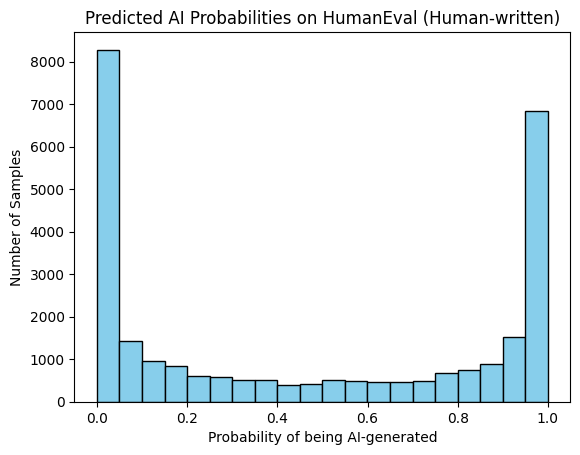

In [ ]:
import matplotlib.pyplot as plt

plt.hist(results['probabilities'], bins=20, color='skyblue', edgecolor='black')
plt.title("Predicted AI Probabilities on HumanEval (Human-written)")
plt.xlabel("Probability of being AI-generated")
plt.ylabel("Number of Samples")
plt.show()


In [ ]:
import sys
import importlib

# If the module is already imported, force a reload
if 'dataset_download' in sys.modules:
    importlib.reload(sys.modules['dataset_download'])
else:
    import dataset_download

In [ ]:
# Test a specific example
test_example = \
"""


Although many individuals who have reflected on the issue would concede that the English language is presently in a state of decline, a prevailing assumption persists that deliberate intervention is largely ineffectual. This resignation is often couched in a broader cultural pessimism: the perceived deterioration of linguistic standards is viewed as a natural corollary of a wider civilizational decay. Consequently, efforts to resist linguistic degradation are frequently dismissed as nostalgic or anachronistic, akin to a preference for obsolete technologies such as candlelight over electricity or horse-drawn carriages over aircraft. Embedded within this dismissal is a deeper, often unexamined presumption—that language evolves autonomously, independent of human agency, rather than being a tool subject to intentional design and refinement.





"""

Test Example:



Although many individuals who have reflected on the issue would concede that the English language is presently in a state of decline, a prevailing assumption persists that deliberate intervention is largely ineffectual. This resignation is often couched in a broader cultural pessimism: the perceived deterioration of linguistic standards is viewed as a natural corollary of a wider civilizational decay. Consequently, efforts to resist linguistic degradation are frequently dismissed as nostalgic or anachronistic, akin to a preference for obsolete technologies such as candlelight over electricity or horse-drawn carriages over aircraft. Embedded within this dismissal is a deeper, often unexamined presumption—that language evolves autonomously, independent of human agency, rather than being a tool subject to intentional design and refinement.







Prediction Results:
Classification: AI-generated
Human probability: 0.1335
AI probability: 0.8665


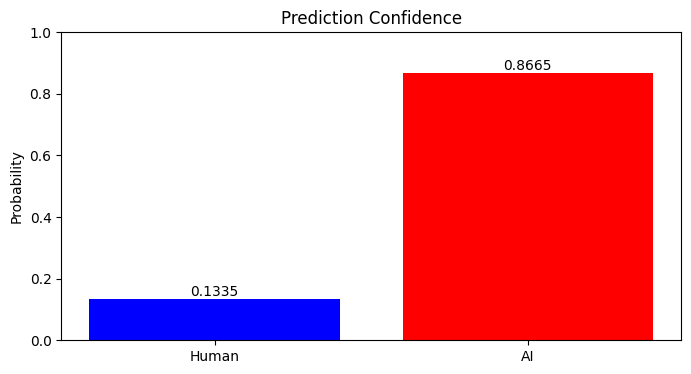

In [ ]:
inputs = tokenizer(
    test_example,
    return_tensors="pt",
    truncation=True,
    padding="max_length",
    max_length=512
).to(device)

model.eval()

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
probs = torch.nn.functional.softmax(logits, dim=1)

prediction = torch.argmax(probs, dim=1).item()
human_prob = probs[0, 0].item()
ai_prob = probs[0, 1].item()

print("Test Example:")
print(test_example)
print("\nPrediction Results:")
print(f"Classification: {'AI-generated' if prediction == 1 else 'Human-written'}")
print(f"Human probability: {human_prob:.4f}")
print(f"AI probability: {ai_prob:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(['Human', 'AI'], [human_prob, ai_prob], color=['blue', 'red'])
plt.title('Prediction Confidence')
plt.ylabel('Probability')
plt.ylim(0, 1)
for i, p in enumerate([human_prob, ai_prob]):
    plt.text(i, p + 0.01, f'{p:.4f}', ha='center')
plt.show()

🔹 Original Text:
 
The ribs are bones that are attached to the spine and help protect the organs in the chest, such as the heart and lungs. While the ribs are generally not able to move or expand on their own, they do move slightly when we breathe. 


🔸 Paraphrased Text (T5):
 The ribs are bones that are attached to the spine and help protect the organs in the chest, such as the heart and lungs . While the ribs are generally not able to move or expand on their own, they do move slightly when we breathe .

📊 RoBERTa Predictions:
Original → AI | Human: 0.0251, AI: 0.9749
Paraphrased → Human | Human: 0.9314, AI: 0.0686


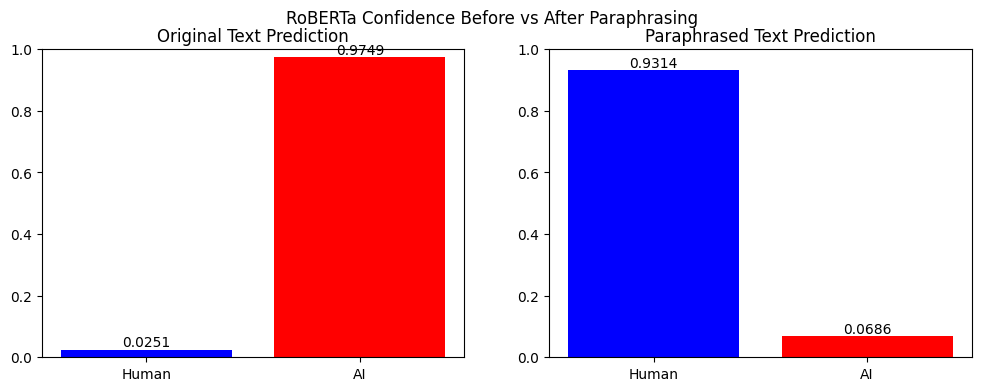

In [ ]:
import random
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

roberta_tokenizer.pad_token = roberta_tokenizer.eos_token
roberta_tokenizer.padding_side = "left"

hc3_ai_df = test_df[test_df["label"] == 1]
test_example = """
The ribs are bones that are attached to the spine and help protect the organs in the chest, \
such as the heart and lungs. While the ribs are generally not able to move or expand on their own, \
they do move slightly when we breathe.
"""

para_tokenizer = AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")
para_model = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws").to(device)
para_model.eval()

input_text = f"paraphrase: {test_example} </s>"
input_ids = para_tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)

with torch.no_grad():
    outputs = para_model.generate(
        input_ids=input_ids,
        max_length=256,
        num_beams=5,
        early_stopping=True
    )

paraphrased = para_tokenizer.decode(outputs[0], skip_special_tokens=True)

def classify_text(text):
    roberta.eval()
    encoded = roberta_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = roberta(**encoded)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()
        human_prob = probs[0, 0].item()
        ai_prob = probs[0, 1].item()
    return prediction, human_prob, ai_prob

pred_orig, h_prob_orig, a_prob_orig = classify_text(test_example)
pred_para, h_prob_para, a_prob_para = classify_text(paraphrased)

print(" Original Text:\n", test_example)
print("\n Paraphrased Text (T5):\n", paraphrased)

print("\n📊 RoBERTa Predictions:")
print(f"Original → {'AI' if pred_orig else 'Human'} | Human: {h_prob_orig:.4f}, AI: {a_prob_orig:.4f}")
print(f"Paraphrased → {'AI' if pred_para else 'Human'} | Human: {h_prob_para:.4f}, AI: {a_prob_para:.4f}")

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].bar(['Human', 'AI'], [h_prob_orig, a_prob_orig], color=['blue', 'red'])
axs[0].set_title('Original Text Prediction')
axs[0].set_ylim(0, 1)
for i, p in enumerate([h_prob_orig, a_prob_orig]):
    axs[0].text(i, p + 0.01, f'{p:.4f}', ha='center')

axs[1].bar(['Human', 'AI'], [h_prob_para, a_prob_para], color=['blue', 'red'])
axs[1].set_title('Paraphrased Text Prediction')
axs[1].set_ylim(0, 1)
for i, p in enumerate([h_prob_para, a_prob_para]):
    axs[1].text(i, p + 0.01, f'{p:.4f}', ha='center')

plt.suptitle('RoBERTa Confidence Before vs After Paraphrasing')
plt.show()


🔹 Original Text:
 
The ribs are bones that are attached to the spine and help protect the organs in the chest,
such as the heart and lungs. While the ribs are generally not able to move or expand on their own,
they do move slightly when we breathe. 


🔸 Paraphrased Text (T5):
 "
The ribs are bones connected to the spine and help shield the organs like heart and lungs in the chest. 
The ribs are generally unable to move or expand independently. But when we breathe,
they indeed shift a little.


📊 RoBERTa Predictions:
Original → AI | Human: 0.0415, AI: 0.9585
Paraphrased → AI | Human: 0.4052, AI: 0.5948


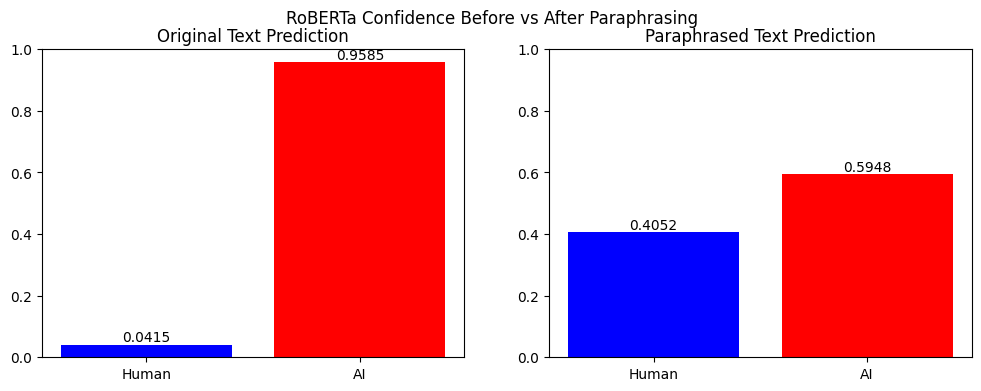

In [ ]:
import random
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

roberta_tokenizer.pad_token = roberta_tokenizer.eos_token
roberta_tokenizer.padding_side = "left"

hc3_ai_df = hc3_df[hc3_df["label"] == 1]
test_example = """
The ribs are bones that are attached to the spine and help protect the organs in the chest,
such as the heart and lungs. While the ribs are generally not able to move or expand on their own,
they do move slightly when we breathe.
"""

paraphrased = """"
The ribs are bones connected to the spine and help shield the organs like heart and lungs in the chest.
The ribs are generally unable to move or expand independently. But when we breathe,
they indeed shift a little.
"""
def classify_text(text):
    roberta.eval()
    encoded = roberta_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = roberta(**encoded)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()
        human_prob = probs[0, 0].item()
        ai_prob = probs[0, 1].item()
    return prediction, human_prob, ai_prob

pred_orig, h_prob_orig, a_prob_orig = classify_text(test_example)
pred_para, h_prob_para, a_prob_para = classify_text(paraphrased)

print(" Original Text:\n", test_example)
print("\n Paraphrased Text (T5):\n", paraphrased)

print("\n📊 RoBERTa Predictions:")
print(f"Original → {'AI' if pred_orig else 'Human'} | Human: {h_prob_orig:.4f}, AI: {a_prob_orig:.4f}")
print(f"Paraphrased → {'AI' if pred_para else 'Human'} | Human: {h_prob_para:.4f}, AI: {a_prob_para:.4f}")

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].bar(['Human', 'AI'], [h_prob_orig, a_prob_orig], color=['blue', 'red'])
axs[0].set_title('Original Text Prediction')
axs[0].set_ylim(0, 1)
for i, p in enumerate([h_prob_orig, a_prob_orig]):
    axs[0].text(i, p + 0.01, f'{p:.4f}', ha='center')

axs[1].bar(['Human', 'AI'], [h_prob_para, a_prob_para], color=['blue', 'red'])
axs[1].set_title('Paraphrased Text Prediction')
axs[1].set_ylim(0, 1)
for i, p in enumerate([h_prob_para, a_prob_para]):
    axs[1].text(i, p + 0.01, f'{p:.4f}', ha='center')

plt.suptitle('RoBERTa Confidence Before vs After Paraphrasing')
plt.show()